<a href="https://colab.research.google.com/github/ritvik94/AI-Powered-Feedback-Generator-for-Student-Performance-Analysis/blob/main/Bank_customer_churn_prediction_using_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [326]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score, confusion_matrix, auc, roc_curve
import collections
from collections import Counter

In [327]:
data = pd.read_csv("/content/Churn_Modelling.csv")

In [328]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [329]:
data.head(100)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,15699461,Fiorentini,515,Spain,Male,35,10,176273.95,1,0,1,121277.78,0
96,97,15738721,Graham,773,Spain,Male,41,9,102827.44,1,0,1,64595.25,0
97,98,15693683,Yuille,814,Germany,Male,29,8,97086.40,2,1,1,197276.13,0
98,99,15604348,Allard,710,Spain,Male,22,8,0.00,2,0,0,99645.04,0


In [330]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Check for null values

In [331]:
data.isna().sum().sum()

np.int64(0)

Check for duplicate values

In [332]:
data.duplicated().sum()

np.int64(0)

In [333]:
newdata = data.drop(data.select_dtypes(include=['object']).columns, axis=1)

In [334]:
newdata.head()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,619,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,608,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,502,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,699,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,850,43,2,125510.82,1,1,1,79084.10,0


In [335]:
newdata.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


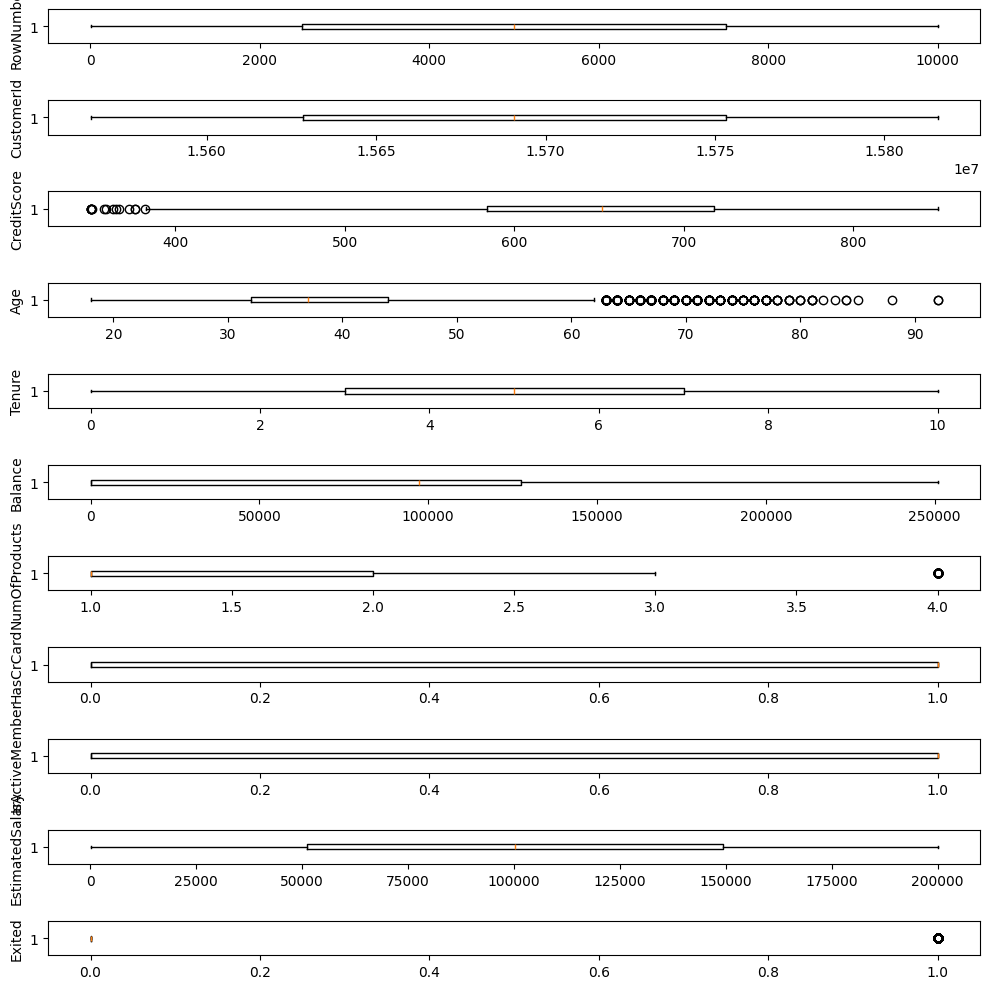

In [336]:
fig, axs = plt.subplots(len(newdata.columns), 1, figsize = (10,10), dpi = 100)
for i, col in enumerate(newdata.columns):
  axs[i].boxplot(newdata[col], vert = False)
  axs[i].set_ylabel(col)
plt.tight_layout()
plt.show()

In [337]:
q1, q3 = np.percentile(newdata['CreditScore'], [25, 75])
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr
newdata = newdata[(newdata['CreditScore'] >= lower) & (newdata['CreditScore'] <= upper)]

In [338]:
q1, q3 = np.percentile(newdata['Age'], [25, 75])
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr
newdata = newdata[(newdata['Age'] >= lower) & (newdata['Age'] <= upper)]

Exited             1.000000
Age                0.358494
Balance            0.116913
EstimatedSalary    0.009123
CustomerId        -0.007380
HasCrCard         -0.008491
Tenure            -0.012872
CreditScore       -0.016413
RowNumber         -0.017240
NumOfProducts     -0.050669
IsActiveMember    -0.143424
Name: Exited, dtype: float64


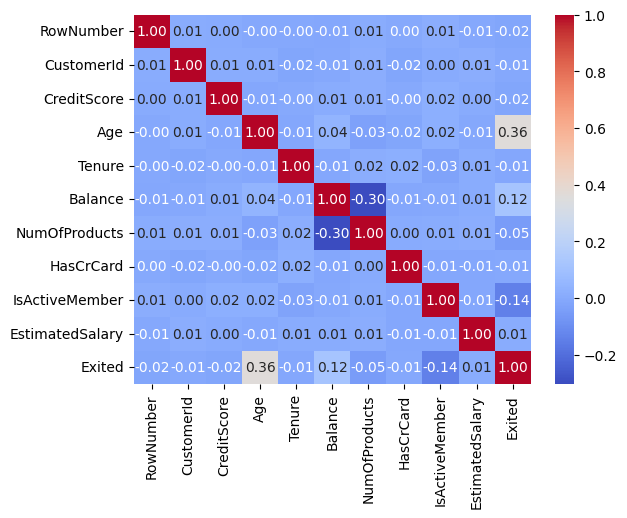

In [339]:
corr = newdata.corr()
plt.figure(dpi=100)
sns.heatmap(corr, annot = True, fmt = '.2f', cmap = 'coolwarm')
print(corr['Exited'].sort_values(ascending=False))

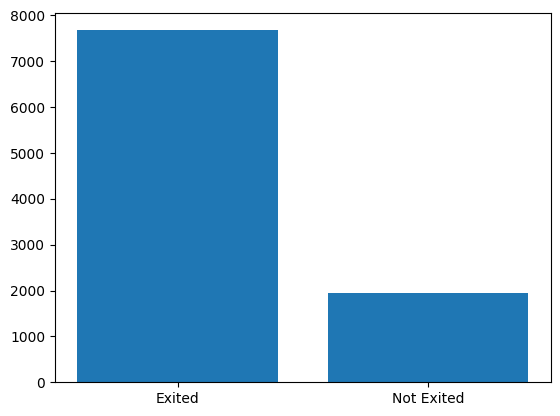

In [340]:
count = newdata['Exited'].value_counts()
plt.bar(count.index, count.values)
plt.xticks([0,1], ['Exited', 'Not Exited'])
plt.show()

In [341]:
x = newdata.drop('Exited', axis =1)
y = newdata['Exited']

In [342]:
counter = Counter(y)
scale = counter[0] / counter[1]

In [343]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(x, y):
    xtrain, xtest = x.iloc[train_idx], x.iloc[test_idx]
    ytrain, ytest = y.iloc[train_idx], y.iloc[test_idx]

In [344]:
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale,
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(xtrain, ytrain)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:40:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [345]:
prediction = xgb_model.predict(xtest)
bal_acc = balanced_accuracy_score(ytest, prediction)
print("Balanced Accuracy:", bal_acc)

Balanced Accuracy: 0.7290314503205129


In [346]:
class_report = classification_report(ytest, prediction)
print(class_report)

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1536
           1       0.58      0.56      0.57       390

    accuracy                           0.83      1926
   macro avg       0.74      0.73      0.73      1926
weighted avg       0.83      0.83      0.83      1926



In [347]:
yprob = xgb_model.predict_proba(xtest)[:, 1]
roc_auc = roc_auc_score(ytest, yprob)
print("roc_auc_score -",roc_auc)

roc_auc_score - 0.8102330395299144


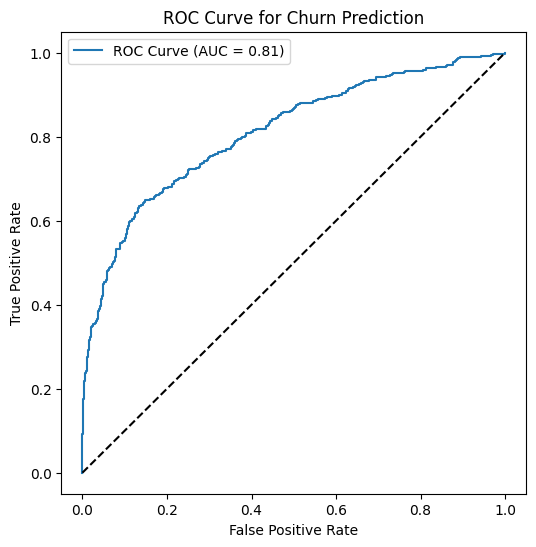

In [348]:
yproba = xgb_model.predict_proba(xtest)[:,1]
fpr, tpr, _ = roc_curve(ytest, yproba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Churn Prediction")
plt.legend()
plt.show()

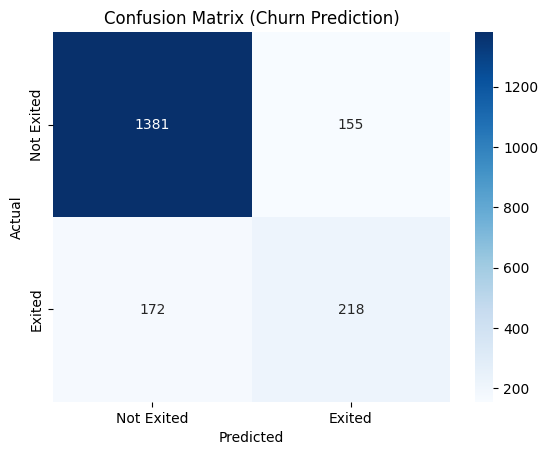

In [349]:
cm = confusion_matrix(ytest, prediction)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Exited", "Exited"],
            yticklabels=["Not Exited", "Exited"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Churn Prediction)")
plt.show()

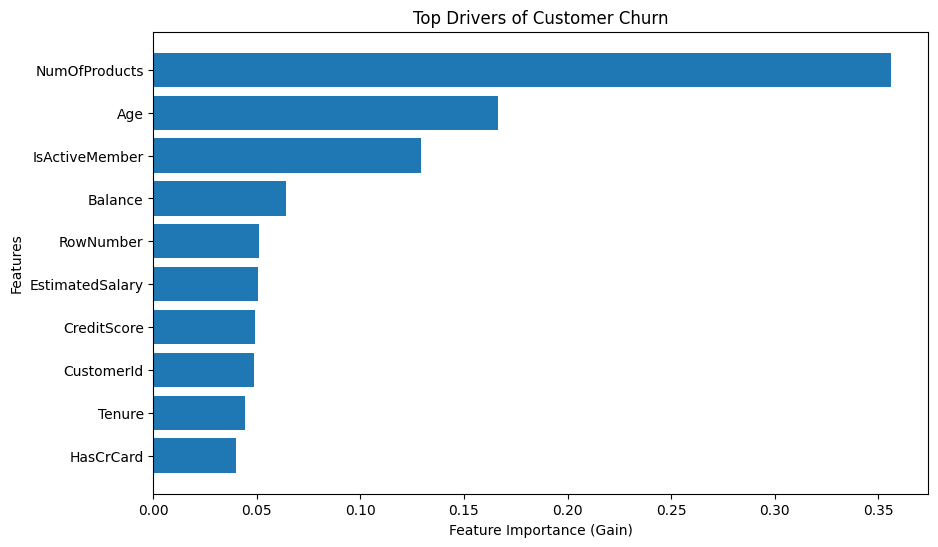

In [350]:
importances = xgb_model.feature_importances_
features = x.columns

sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.barh([features[i] for i in sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance (Gain)")
plt.ylabel("Features")
plt.title("Top Drivers of Customer Churn")
plt.gca().invert_yaxis()
plt.show()